<a href="https://colab.research.google.com/github/thihanaung-thnn/TBXray_classification/blob/main/01_training_6models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!unzip -qq /content/drive/MyDrive/Tensorflow/TB_classification/archive.zip

In [3]:
import os
import shutil
import pathlib
original_dir = pathlib.Path('TB_Chest_Radiography_Database')
new_base_dir = pathlib.Path('TB_Vs_Normal')

def make_subset(subset_name, start_n, end_n, start_tb, end_tb):

    dir_normal = new_base_dir / subset_name / 'Normal'
    dir_tb = new_base_dir / subset_name / 'Tuberculosis'
    os.makedirs(dir_normal)
    os.makedirs(dir_tb)
    
    fnames_n = [f"Normal-{i}.png" for i in range(start_n, end_n)]
    for fname in fnames_n:
        shutil.copyfile(src=original_dir / 'Normal' / fname, 
                       dst=dir_normal / fname)
    
    fnames_tb = [f"Tuberculosis-{i}.png" 
                for i in range(start_tb, end_tb)]
    for fname in fnames_tb:
        shutil.copyfile(src=original_dir / 'Tuberculosis' / fname, 
                       dst=dir_tb / fname)
        
make_subset('train', 1, 2241, 1, 449)
make_subset('validation', 2241, 2241+560, 449, 449+112)
make_subset('test', 2241+560, 2241+560+700, 449+112, 449+112+140)

In [4]:
from tensorflow.keras.utils import image_dataset_from_directory, plot_model
from tensorflow import keras 
import tensorflow as tf 
# from keras.applications.inception_v3 import InceptionV3 
# from keras.applications.resnet import ResNet50

In [5]:
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
IMG_SHAPE = (224, 224, 3)
TRAIN_SAMPLES = 2240+448
VAL_SAMPLES = 560+112

train_dataset = image_dataset_from_directory(
    new_base_dir / 'train', 
    image_size=IMG_SIZE, 
    batch_size=BATCH_SIZE,
)

validation_dataset = image_dataset_from_directory(
    new_base_dir / 'validation',
    image_size=IMG_SIZE, 
    batch_size=BATCH_SIZE
)

test_dataset = image_dataset_from_directory(
    new_base_dir / 'test',
    image_size=IMG_SIZE, 
    batch_size=BATCH_SIZE
)

Found 2688 files belonging to 2 classes.
Found 672 files belonging to 2 classes.
Found 840 files belonging to 2 classes.


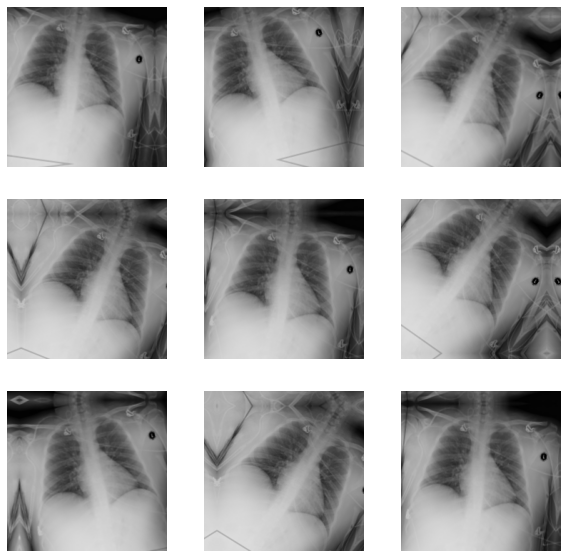

In [ ]:
import matplotlib.pyplot as plt
data_augmentation = keras.Sequential([
                                      keras.layers.RandomRotation(0.1),
                                      keras.layers.RandomTranslation(
                                          height_factor=(-0.1, 0.1),
                                          width_factor=(-0.1, 0.1)
                                      ),
])
plt.figure(figsize=(10,10))
for images, _ in train_dataset.take(1):
    for i in range(9):
        aug_img = data_augmentation(images)
        ax = plt.subplot(3,3,i+1)
        plt.imshow(aug_img[0].numpy().astype('uint8'))
        plt.axis('off')

In [6]:
COUNT_NORMAL = 3500
COUNT_TB = 700
# training samples / (2* all normal count)
weight_for_nl = (1/COUNT_NORMAL)*(2240+448) / 2.0
# training_samples / (2*tb count)
weight_for_tb = (1/COUNT_TB)*(2240+448) / 2.0
class_weight = {0: weight_for_nl, 1: weight_for_tb}
print(class_weight)

{0: 0.384, 1: 1.92}


In [7]:
METRICS = ['accuracy', 
           keras.metrics.Recall(name='recall'),
           keras.metrics.Precision(name='precision'), 
]

In [15]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)

# ResNet 50

In [9]:
preprocess_input = tf.keras.applications.resnet50.preprocess_input
base_model = tf.keras.applications.ResNet50(
    input_shape=IMG_SHAPE, 
    include_top=False, 
    weights='imagenet'
)
base_model.trainable = False 
inputs = keras.Input(shape=IMG_SHAPE)
x = keras.layers.Normalization()(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dropout(0.25)(x)
x = keras.layers.Dense(128, activation='relu')(x)
x = keras.layers.Dropout(0.25)(x)
outputs = keras.layers.Dense(1, activation='sigmoid')(x)
model_resnet50 = keras.Model(inputs, outputs)
model_resnet50.compile(
    optimizer = keras.optimizers.Adam(lr=0.001),
    loss = 'binary_crossentropy',
    metrics=METRICS
)
callbacks = [
             keras.callbacks.ModelCheckpoint(
                 'resnet50.h5', save_best_only=True
             ),
             keras.callbacks.EarlyStopping(
                 patience=5, restore_best_weights=True
             )
]
plot_model(model_resnet50, 'resnet50.png', show_shapes=True)
history_resnet50 = model_resnet50.fit(
    train_dataset, 
    steps_per_epoch=TRAIN_SAMPLES//BATCH_SIZE, 
    validation_data = validation_dataset, 
    validation_steps = VAL_SAMPLES//BATCH_SIZE,
    epochs=20, 
    callbacks=callbacks, 
    class_weight=class_weight
)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/20
84/84 [==============================] - ETA: 0s - loss: 0.1018 - accuracy: 0.9353 - recall: 0.9375 - precision: 0.7766

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


84/84 [==============================] - 34s 336ms/step - loss: 0.1018 - accuracy: 0.9353 - recall: 0.9375 - precision: 0.7766 - val_loss: 0.0515 - val_accuracy: 0.9836 - val_recall: 0.9196 - val_precision: 0.9810
Epoch 2/20
84/84 [==============================] - 29s 323ms/step - loss: 0.0359 - accuracy: 0.9788 - recall: 0.9799 - precision: 0.9014 - val_loss: 0.0366 - val_accuracy: 0.9896 - val_recall: 0.9732 - val_precision: 0.9646
Epoch 3/20
84/84 [==============================] - 27s 309ms/step - loss: 0.0177 - accuracy: 0.9911 - recall: 0.9911 - precision: 0.9569 - val_loss: 0.0747 - val_accuracy: 0.9702 - val_recall: 0.9821 - val_precision: 0.8594
Epoch 4/20
84/84 [==============================] - 27s 306ms/step - loss: 0.0163 - accuracy: 0.9911 - recall: 0.9911 - precision: 0.9569 - val_loss: 0.0380 - val_accuracy: 0.9881 - val_recall: 0.9464 - val_precision: 0.9815
Epoch 5/20
84/84 [==============================] - 27s 308ms/step - loss: 0.0121 - accuracy: 0.9918 - recall: 

In [10]:
import numpy as np 
from sklearn.metrics import classification_report, confusion_matrix

def prediction(model_name, dataset=test_dataset, threshold=0.5):
    all_features, all_labels = [], []
    for images, labels in dataset:
        features = model_name.predict(images)
        all_features.append(features)
        all_labels.append(labels)

    all_features = np.concatenate(all_features) 
    preds = all_features > threshold
    y_true = np.concatenate(all_labels)

    print(classification_report(y_true, preds))
    print(confusion_matrix(y_true, preds))

    return all_features, y_true


In [11]:
r50_preds, y_true = prediction(model_resnet50)

              precision    recall  f1-score   support

           0       1.00      0.99      0.99       700
           1       0.96      0.98      0.97       140

    accuracy                           0.99       840
   macro avg       0.98      0.98      0.98       840
weighted avg       0.99      0.99      0.99       840

[[694   6]
 [  3 137]]


## Fine tune 

In [31]:
for layer in base_model.layers[-4:]:
    layer.trainable = True 

callbacks = [
             keras.callbacks.ModelCheckpoint(
                 'resnet50.h5', save_best_only=True
             ),
             keras.callbacks.EarlyStopping(
                 patience=5, restore_best_weights=True
             )
]
plot_model(model_resnet50, 'resnet50.png', show_shapes=True)
history_resnet50 = model_resnet50.fit(
    train_dataset, 
    steps_per_epoch=TRAIN_SAMPLES//BATCH_SIZE, 
    validation_data = validation_dataset, 
    validation_steps = VAL_SAMPLES//BATCH_SIZE,
    epochs=10, 
    callbacks=callbacks, 
    class_weight=class_weight
)

Epoch 1/10
84/84 [==============================] - ETA: 0s - loss: 0.0337 - accuracy: 0.9833 - recall: 0.9799 - precision: 0.9242

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


84/84 [==============================] - 28s 320ms/step - loss: 0.0337 - accuracy: 0.9833 - recall: 0.9799 - precision: 0.9242 - val_loss: 0.0640 - val_accuracy: 0.9807 - val_recall: 0.9911 - val_precision: 0.9024
Epoch 2/10
84/84 [==============================] - 28s 317ms/step - loss: 0.0180 - accuracy: 0.9907 - recall: 0.9911 - precision: 0.9548 - val_loss: 0.0305 - val_accuracy: 0.9911 - val_recall: 0.9643 - val_precision: 0.9818
Epoch 3/10
84/84 [==============================] - 28s 310ms/step - loss: 0.0079 - accuracy: 0.9967 - recall: 0.9978 - precision: 0.9824 - val_loss: 0.0438 - val_accuracy: 0.9851 - val_recall: 0.9911 - val_precision: 0.9250
Epoch 4/10
84/84 [==============================] - 27s 303ms/step - loss: 0.0088 - accuracy: 0.9948 - recall: 0.9978 - precision: 0.9717 - val_loss: 0.0371 - val_accuracy: 0.9881 - val_recall: 0.9464 - val_precision: 0.9815
Epoch 5/10
84/84 [==============================] - 27s 305ms/step - loss: 0.0143 - accuracy: 0.9933 - recall: 

In [32]:
r50_preds, y_true = prediction(model_resnet50)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       700
           1       0.99      0.99      0.99       140

    accuracy                           1.00       840
   macro avg       0.99      0.99      0.99       840
weighted avg       1.00      1.00      1.00       840

[[698   2]
 [  2 138]]


# ResNet 101

In [71]:
preprocess_input = tf.keras.applications.resnet50.preprocess_input
base_model_rn101 = tf.keras.applications.ResNet101(
    input_shape=IMG_SHAPE, 
    include_top=False, 
    weights='imagenet'
)
base_model_rn101.trainable = False 
inputs = keras.Input(shape=IMG_SHAPE)
x = keras.layers.Normalization()(inputs)
x = preprocess_input(x)
x = base_model_rn101(x, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dropout(0.25)(x)
x = keras.layers.Dense(128, activation='relu')(x)
x = keras.layers.Dropout(0.25)(x)
outputs = keras.layers.Dense(1, activation='sigmoid')(x)
model_resnet101 = keras.Model(inputs, outputs)
model_resnet101.compile(
    optimizer = keras.optimizers.Adam(lr=0.001),
    loss = 'binary_crossentropy',
    metrics=METRICS
)
callbacks = [
             keras.callbacks.ModelCheckpoint(
                 'resnet101.h5', save_best_only=True
             ),
             keras.callbacks.EarlyStopping(
                 patience=5, restore_best_weights=True
             )
]
plot_model(model_resnet101, 'resnet101.png', show_shapes=True)
history_resnet101 = model_resnet101.fit(
    train_dataset, 
    steps_per_epoch=TRAIN_SAMPLES//BATCH_SIZE, 
    validation_data = validation_dataset, 
    validation_steps = VAL_SAMPLES//BATCH_SIZE,
    epochs=20, 
    callbacks=callbacks, 
    class_weight=class_weight
)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/20
84/84 [==============================] - ETA: 0s - loss: 0.1633 - accuracy: 0.9115 - recall: 0.9167 - precision: 0.7333

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


84/84 [==============================] - 55s 538ms/step - loss: 0.1633 - accuracy: 0.9115 - recall: 0.9167 - precision: 0.7333 - val_loss: 0.0597 - val_accuracy: 0.9836 - val_recall: 0.9554 - val_precision: 0.9469
Epoch 2/20
84/84 [==============================] - 42s 476ms/step - loss: 0.0397 - accuracy: 0.9807 - recall: 0.9821 - precision: 0.9091 - val_loss: 0.0750 - val_accuracy: 0.9792 - val_recall: 0.9732 - val_precision: 0.9083
Epoch 3/20
84/84 [==============================] - 44s 499ms/step - loss: 0.0338 - accuracy: 0.9814 - recall: 0.9777 - precision: 0.9163 - val_loss: 0.0529 - val_accuracy: 0.9896 - val_recall: 0.9732 - val_precision: 0.9646
Epoch 4/20
84/84 [==============================] - 44s 502ms/step - loss: 0.0256 - accuracy: 0.9859 - recall: 0.9866 - precision: 0.9325 - val_loss: 0.0450 - val_accuracy: 0.9896 - val_recall: 0.9732 - val_precision: 0.9646
Epoch 5/20
84/84 [==============================] - 42s 481ms/step - loss: 0.0177 - accuracy: 0.9900 - recall: 

In [72]:
r101_preds, y_true = prediction(model_resnet101)

              precision    recall  f1-score   support

           0       1.00      0.99      0.99       700
           1       0.96      0.98      0.97       140

    accuracy                           0.99       840
   macro avg       0.98      0.99      0.98       840
weighted avg       0.99      0.99      0.99       840

[[695   5]
 [  3 137]]


In [73]:
model_resnet101.evaluate(test_dataset)

27/27 [==============================] - 11s 363ms/step - loss: 0.0278 - accuracy: 0.9905 - recall: 0.9786 - precision: 0.9648


[0.027806995436549187,
 0.9904761910438538,
 0.9785714149475098,
 0.9647887349128723]

## Fine Tune

In [74]:
for layer in base_model_rn101.layers[-7:]:
    layer.trainable = True 

callbacks = [
             keras.callbacks.ModelCheckpoint(
                 'resnet101_finetune.h5', save_best_only=True
             )
]

history_resnet101 = model_resnet101.fit(
    train_dataset, 
    steps_per_epoch=TRAIN_SAMPLES//BATCH_SIZE, 
    validation_data = validation_dataset, 
    validation_steps = VAL_SAMPLES//BATCH_SIZE,
    epochs=10, 
    callbacks=callbacks, 
    class_weight=class_weight
)

Epoch 1/10
84/84 [==============================] - ETA: 0s - loss: 0.0237 - accuracy: 0.9877 - recall: 0.9844 - precision: 0.9443

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


84/84 [==============================] - 43s 493ms/step - loss: 0.0237 - accuracy: 0.9877 - recall: 0.9844 - precision: 0.9443 - val_loss: 0.0430 - val_accuracy: 0.9896 - val_recall: 0.9643 - val_precision: 0.9730
Epoch 2/10
84/84 [==============================] - 41s 471ms/step - loss: 0.0233 - accuracy: 0.9862 - recall: 0.9844 - precision: 0.9363 - val_loss: 0.0603 - val_accuracy: 0.9866 - val_recall: 0.9732 - val_precision: 0.9478
Epoch 3/10
84/84 [==============================] - 42s 477ms/step - loss: 0.0156 - accuracy: 0.9892 - recall: 0.9888 - precision: 0.9486 - val_loss: 0.0591 - val_accuracy: 0.9851 - val_recall: 0.9554 - val_precision: 0.9554
Epoch 4/10
84/84 [==============================] - 41s 470ms/step - loss: 0.0143 - accuracy: 0.9926 - recall: 0.9933 - precision: 0.9632 - val_loss: 0.0583 - val_accuracy: 0.9881 - val_recall: 0.9375 - val_precision: 0.9906
Epoch 5/10
84/84 [==============================] - 42s 476ms/step - loss: 0.0117 - accuracy: 0.9937 - recall: 

In [75]:
r101_preds, y_true = prediction(model_resnet101)

              precision    recall  f1-score   support

           0       1.00      0.99      1.00       700
           1       0.97      1.00      0.99       140

    accuracy                           1.00       840
   macro avg       0.99      1.00      0.99       840
weighted avg       1.00      1.00      1.00       840

[[696   4]
 [  0 140]]


In [76]:
model_resnet101.evaluate(test_dataset)

27/27 [==============================] - 12s 369ms/step - loss: 0.0113 - accuracy: 0.9952 - recall: 1.0000 - precision: 0.9722


[0.011323926970362663, 0.9952380657196045, 1.0, 0.9722222089767456]

In [82]:
print(confusion_matrix(y_true, r101_preds > 0.7))
print(classification_report(y_true, r101_preds > 0.7))

[[698   2]
 [  2 138]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       700
           1       0.99      0.99      0.99       140

    accuracy                           1.00       840
   macro avg       0.99      0.99      0.99       840
weighted avg       1.00      1.00      1.00       840



# VGG 16

In [18]:
preprocess_input = tf.keras.applications.vgg16.preprocess_input
base_model_vgg16 = tf.keras.applications.VGG16(
    input_shape=IMG_SHAPE, 
    include_top=False, 
    weights='imagenet'
)
base_model_vgg16.trainable = False 
inputs = keras.Input(shape=IMG_SHAPE)
x = keras.layers.Normalization()(inputs)
x = preprocess_input(x)
x = base_model_vgg16(x, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dropout(0.25)(x)
x = keras.layers.Dense(128, activation='relu')(x)
x = keras.layers.Dropout(0.25)(x)
outputs = keras.layers.Dense(1, activation='sigmoid')(x)
model_vgg16 = keras.Model(inputs, outputs)
model_vgg16.compile(
    optimizer = keras.optimizers.Adam(learning_rate=0.001),
    loss = 'binary_crossentropy',
    metrics=METRICS
)
callbacks = [
             keras.callbacks.ModelCheckpoint(
                 'vgg16.h5', save_best_only=True
             ),
             keras.callbacks.EarlyStopping(
                 patience=5, restore_best_weights=True
             )
]
plot_model(base_model_vgg16, 'base_vgg16.png', show_shapes=True)
plot_model(model_vgg16, 'vgg16.png', show_shapes=True)
history_vgg16 = model_vgg16.fit(
    train_dataset, 
    steps_per_epoch=TRAIN_SAMPLES//BATCH_SIZE, 
    validation_data = validation_dataset, 
    validation_steps = VAL_SAMPLES//BATCH_SIZE,
    epochs=20, 
    callbacks=callbacks, 
    class_weight=class_weight
)

58900480/58889256 [==============================] - 1s 0us/step
Epoch 1/20
84/84 [==============================] - 41s 335ms/step - loss: 0.2067 - accuracy: 0.8884 - recall: 0.8786 - precision: 0.6740 - val_loss: 0.2077 - val_accuracy: 0.9167 - val_recall: 0.9821 - val_precision: 0.6707
Epoch 2/20
84/84 [==============================] - 29s 327ms/step - loss: 0.0910 - accuracy: 0.9453 - recall: 0.9353 - precision: 0.7803 - val_loss: 0.0626 - val_accuracy: 0.9747 - val_recall: 0.9732 - val_precision: 0.8862
Epoch 3/20
84/84 [==============================] - 29s 325ms/step - loss: 0.0608 - accuracy: 0.9688 - recall: 0.9598 - precision: 0.8669 - val_loss: 0.0987 - val_accuracy: 0.9568 - val_recall: 0.9821 - val_precision: 0.8029
Epoch 4/20
84/84 [==============================] - 29s 326ms/step - loss: 0.0613 - accuracy: 0.9654 - recall: 0.9509 - precision: 0.8571 - val_loss: 0.0923 - val_accuracy: 0.9673 - val_recall: 0.9911 - val_precision: 0.8409
Epoch 5/20
84/84 [=================

In [19]:
vgg16_preds, y_true = prediction(model_vgg16)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       700
           1       0.98      0.99      0.99       140

    accuracy                           1.00       840
   macro avg       0.99      0.99      0.99       840
weighted avg       1.00      1.00      1.00       840

[[697   3]
 [  1 139]]


In [20]:
model_vgg16.evaluate(test_dataset)

27/27 [==============================] - 9s 257ms/step - loss: 0.0192 - accuracy: 0.9952 - recall: 0.9929 - precision: 0.9789


[0.019231004640460014,
 0.9952380657196045,
 0.9928571581840515,
 0.9788732528686523]

# VGG 19

In [22]:
preprocess_input = tf.keras.applications.vgg19.preprocess_input
base_model_vgg19 = tf.keras.applications.VGG19(
    input_shape=IMG_SHAPE, 
    include_top=False, 
    weights='imagenet'
)
base_model_vgg19.trainable = False 
inputs = keras.Input(shape=IMG_SHAPE)
x = keras.layers.Normalization()(inputs)
x = preprocess_input(x)
x = base_model_vgg19(x, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dropout(0.25)(x)
x = keras.layers.Dense(128, activation='relu')(x)
x = keras.layers.Dropout(0.25)(x)
outputs = keras.layers.Dense(1, activation='sigmoid')(x)
model_vgg19 = keras.Model(inputs, outputs)
model_vgg19.compile(
    optimizer = keras.optimizers.Adam(learning_rate=0.001),
    loss = 'binary_crossentropy',
    metrics=METRICS
)
callbacks = [
             keras.callbacks.ModelCheckpoint(
                 'vgg19.h5', save_best_only=True
             ),
             keras.callbacks.EarlyStopping(
                 patience=5, restore_best_weights=True
             )
]
plot_model(base_model_vgg19, 'base_vgg19.png', show_shapes=True)
plot_model(model_vgg19, 'vgg19.png', show_shapes=True)
history_vgg19 = model_vgg19.fit(
    train_dataset, 
    steps_per_epoch=TRAIN_SAMPLES//BATCH_SIZE, 
    validation_data = validation_dataset, 
    validation_steps = VAL_SAMPLES//BATCH_SIZE,
    epochs=20, 
    callbacks=callbacks, 
    class_weight=class_weight
)

80150528/80134624 [==============================] - 1s 0us/step
Epoch 1/20
84/84 [==============================] - 36s 390ms/step - loss: 0.2522 - accuracy: 0.8921 - recall: 0.8946 - precision: 0.6930 - val_loss: 0.1666 - val_accuracy: 0.9479 - val_recall: 0.9643 - val_precision: 0.7770
Epoch 2/20
84/84 [==============================] - 34s 383ms/step - loss: 0.1110 - accuracy: 0.9446 - recall: 0.9308 - precision: 0.7794 - val_loss: 0.1366 - val_accuracy: 0.9524 - val_recall: 0.9821 - val_precision: 0.7857
Epoch 3/20
84/84 [==============================] - 34s 385ms/step - loss: 0.0741 - accuracy: 0.9594 - recall: 0.9531 - precision: 0.8291 - val_loss: 0.1013 - val_accuracy: 0.9583 - val_recall: 0.9554 - val_precision: 0.8231
Epoch 4/20
84/84 [==============================] - 34s 387ms/step - loss: 0.0532 - accuracy: 0.9702 - recall: 0.9598 - precision: 0.8740 - val_loss: 0.0836 - val_accuracy: 0.9628 - val_recall: 0.9643 - val_precision: 0.8372
Epoch 5/20
84/84 [=================

In [ ]:
history_vgg19 = model_vgg19.fit(
    train_dataset, 
    steps_per_epoch=TRAIN_SAMPLES//BATCH_SIZE, 
    validation_data = validation_dataset, 
    validation_steps = VAL_SAMPLES//BATCH_SIZE,
    epochs=10, 
    callbacks=callbacks, 
    class_weight=class_weight
)

Epoch 1/10
84/84 [==============================] - 22s 249ms/step - loss: 0.0254 - accuracy: 0.9877 - recall: 0.9844 - precision: 0.9443 - val_loss: 0.0657 - val_accuracy: 0.9807 - val_recall: 0.9018 - val_precision: 0.9806
Epoch 2/10
84/84 [==============================] - 22s 249ms/step - loss: 0.0126 - accuracy: 0.9937 - recall: 0.9933 - precision: 0.9695 - val_loss: 0.0570 - val_accuracy: 0.9851 - val_recall: 0.9196 - val_precision: 0.9904
Epoch 3/10
84/84 [==============================] - 22s 248ms/step - loss: 0.0125 - accuracy: 0.9914 - recall: 0.9911 - precision: 0.9590 - val_loss: 0.0495 - val_accuracy: 0.9851 - val_recall: 0.9643 - val_precision: 0.9474
Epoch 4/10
84/84 [==============================] - 22s 248ms/step - loss: 0.0134 - accuracy: 0.9940 - recall: 0.9978 - precision: 0.9675 - val_loss: 0.0532 - val_accuracy: 0.9866 - val_recall: 0.9375 - val_precision: 0.9813
Epoch 5/10
84/84 [==============================] - 22s 252ms/step - loss: 0.0165 - accuracy: 0.9926

In [23]:
vgg19_preds, y_true = prediction(model_vgg19)

              precision    recall  f1-score   support

           0       0.99      1.00      0.99       700
           1       1.00      0.94      0.97       140

    accuracy                           0.99       840
   macro avg       0.99      0.97      0.98       840
weighted avg       0.99      0.99      0.99       840

[[700   0]
 [  8 132]]


In [28]:
print(classification_report(y_true, vgg19_preds > 0.1))
confusion_matrix(y_true, vgg19_preds > 0.1)

              precision    recall  f1-score   support

           0       1.00      0.99      0.99       700
           1       0.95      1.00      0.98       140

    accuracy                           0.99       840
   macro avg       0.98      0.99      0.99       840
weighted avg       0.99      0.99      0.99       840



array([[693,   7],
       [  0, 140]])

# DenseNet 201

In [41]:
preprocess_input = tf.keras.applications.densenet.preprocess_input
base_model_dense201 = tf.keras.applications.DenseNet201(
    input_shape=IMG_SHAPE, 
    include_top=False, 
    weights='imagenet'
)
base_model_dense201.trainable = False 
inputs = keras.Input(shape=IMG_SHAPE)
x = keras.layers.Normalization()(inputs)
x = preprocess_input(x)
x = base_model_dense201(x, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dropout(0.25)(x)
x = keras.layers.Dense(128, activation='relu')(x)
x = keras.layers.Dropout(0.25)(x)
outputs = keras.layers.Dense(1, activation='sigmoid')(x)
model_dense201 = keras.Model(inputs, outputs)
model_dense201.compile(
    optimizer = keras.optimizers.Adam(learning_rate=0.001),
    loss = 'binary_crossentropy',
    metrics=METRICS
)
callbacks = [
             keras.callbacks.ModelCheckpoint(
                 'dense201.h5', save_best_only=True
             ),
             keras.callbacks.EarlyStopping(
                 patience=5, restore_best_weights=True
             )
]
plot_model(base_model_dense201, 'base_dense201.png', show_shapes=True)
plot_model(model_dense201, 'dense201.png', show_shapes=True)
history_dense201 = model_dense201.fit(
    train_dataset, 
    steps_per_epoch=TRAIN_SAMPLES//BATCH_SIZE, 
    validation_data = validation_dataset, 
    validation_steps = VAL_SAMPLES//BATCH_SIZE,
    epochs=20, 
    callbacks=callbacks, 
    class_weight=class_weight
)

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.418994 to fit

Epoch 1/20
84/84 [==============================] - 58s 518ms/step - loss: 0.1187 - accuracy: 0.9267 - recall: 0.9487 - precision: 0.8167 - val_loss: 0.1111 - val_accuracy: 0.9613 - val_recall: 0.9643 - val_precision: 0.8308
Epoch 2/20
84/84 [==============================] - 41s 476ms/step - loss: 0.0586 - accuracy: 0.9680 - recall: 0.9643 - precision: 0.8606 - val_loss: 0.0873 - val_accuracy: 0.9732 - val_recall: 0.9643 - val_precision: 0.8852
Epoch 3/20
84/84 [==============================] - 42s 478ms/step - loss: 0.0410 - accuracy: 0.9818 - recall: 0.9799 - precision: 0.9165 - val_loss: 0.0601 - val_accuracy: 0.9807 - val_recall: 0.9643 - val_precision: 0.9231
Epoch 4/20
84/84 [==============================] - 42s 478ms/step - loss: 0.0335 - accuracy: 0.9825 - recall: 0.9888 - precision: 0.9134 - val_loss: 0.0405 - val_accuracy: 0.9881 - val_recall: 0.9375 - val_precision: 0.9906
Epoch 5/20
84/84 [==

In [42]:
dense201_preds, y_true = prediction(model_dense201)

              precision    recall  f1-score   support

           0       1.00      0.99      1.00       700
           1       0.97      0.99      0.98       140

    accuracy                           0.99       840
   macro avg       0.99      0.99      0.99       840
weighted avg       0.99      0.99      0.99       840

[[696   4]
 [  1 139]]


## Fine Tune

In [46]:
for layer in base_model_dense201.layers[-7:]:
    layer.trainable = True 

callbacks = [
             keras.callbacks.ModelCheckpoint(
                 'dense201_finetune.h5', save_best_only=True
             )
]

history_dense201 = model_dense201.fit(
    train_dataset, 
    steps_per_epoch=TRAIN_SAMPLES//BATCH_SIZE, 
    validation_data = validation_dataset, 
    validation_steps = VAL_SAMPLES//BATCH_SIZE,
    epochs=10, 
    callbacks=callbacks, 
    class_weight=class_weight
)

Epoch 1/10
84/84 [==============================] - 41s 473ms/step - loss: 0.0203 - accuracy: 0.9888 - recall: 0.9888 - precision: 0.9466 - val_loss: 0.1029 - val_accuracy: 0.9598 - val_recall: 0.9821 - val_precision: 0.8148
Epoch 2/10
84/84 [==============================] - 40s 463ms/step - loss: 0.0117 - accuracy: 0.9940 - recall: 0.9933 - precision: 0.9716 - val_loss: 0.0396 - val_accuracy: 0.9896 - val_recall: 0.9643 - val_precision: 0.9730
Epoch 3/10
84/84 [==============================] - 40s 459ms/step - loss: 0.0154 - accuracy: 0.9911 - recall: 0.9933 - precision: 0.9549 - val_loss: 0.0440 - val_accuracy: 0.9851 - val_recall: 0.9732 - val_precision: 0.9397
Epoch 4/10
84/84 [==============================] - 40s 459ms/step - loss: 0.0361 - accuracy: 0.9851 - recall: 0.9844 - precision: 0.9304 - val_loss: 0.0671 - val_accuracy: 0.9851 - val_recall: 0.9107 - val_precision: 1.0000
Epoch 5/10
84/84 [==============================] - 41s 475ms/step - loss: 0.0134 - accuracy: 0.9918

In [47]:
dense201_preds, y_true = prediction(model_dense201)

              precision    recall  f1-score   support

           0       1.00      0.99      0.99       700
           1       0.95      1.00      0.98       140

    accuracy                           0.99       840
   macro avg       0.98      0.99      0.99       840
weighted avg       0.99      0.99      0.99       840

[[693   7]
 [  0 140]]


In [57]:
print(classification_report(y_true, dense201_preds > 0.7))
confusion_matrix(y_true, dense201_preds > 0.7)

              precision    recall  f1-score   support

           0       1.00      0.99      1.00       700
           1       0.97      1.00      0.98       140

    accuracy                           0.99       840
   macro avg       0.98      1.00      0.99       840
weighted avg       0.99      0.99      0.99       840



array([[695,   5],
       [  0, 140]])

In [58]:
model_dense201.evaluate(test_dataset)

27/27 [==============================] - 11s 355ms/step - loss: 0.0218 - accuracy: 0.9917 - recall: 1.0000 - precision: 0.9524


[0.021797770634293556, 0.9916666746139526, 1.0, 0.9523809552192688]

# MobileNet V2

In [65]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input
base_model_mobn2 = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=True,
                                               weights='imagenet')

base_model_mobn2.trainable = False 
inputs = keras.Input(shape=IMG_SHAPE)
x = keras.layers.Normalization()(inputs)
x = preprocess_input(x)
x = base_model_mobn2(x, training=False)
x = keras.layers.Dense(256, activation='relu')(x)
x = keras.layers.Dropout(0.25)(x)
x = keras.layers.Dense(128, activation='relu')(x)
x = keras.layers.Dropout(0.25)(x)
outputs = keras.layers.Dense(1, activation='sigmoid')(x)
model_mobn2 = keras.Model(inputs, outputs)
model_mobn2.compile(
    optimizer = keras.optimizers.Adam(learning_rate=0.001),
    loss = 'binary_crossentropy',
    metrics=METRICS
)
callbacks = [
             keras.callbacks.ModelCheckpoint(
                 'mobn2.h5', save_best_only=True
             ),
             keras.callbacks.EarlyStopping(
                 patience=5, restore_best_weights=True
             )
]
plot_model(base_model_mobn2, 'base_mobn2.png', show_shapes=True)
plot_model(model_mobn2, 'mobn2.png', show_shapes=True)
history_vgg19 = model_mobn2.fit(
    train_dataset, 
    steps_per_epoch=TRAIN_SAMPLES//BATCH_SIZE, 
    validation_data = validation_dataset, 
    validation_steps = VAL_SAMPLES//BATCH_SIZE,
    epochs=20, 
    callbacks=callbacks, 
    class_weight=class_weight
)

Epoch 1/20
84/84 [==============================] - ETA: 0s - loss: 0.3752 - accuracy: 0.7932 - recall: 0.7194 - precision: 0.5152

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


84/84 [==============================] - 74s 272ms/step - loss: 0.3752 - accuracy: 0.7932 - recall: 0.7194 - precision: 0.5152 - val_loss: 0.3993 - val_accuracy: 0.8571 - val_recall: 0.8839 - val_precision: 0.5440
Epoch 2/20
84/84 [==============================] - 25s 274ms/step - loss: 0.1787 - accuracy: 0.9022 - recall: 0.9129 - precision: 0.6461 - val_loss: 0.2753 - val_accuracy: 0.8795 - val_recall: 0.8839 - val_precision: 0.5928
Epoch 3/20
84/84 [==============================] - 25s 282ms/step - loss: 0.1188 - accuracy: 0.9379 - recall: 0.9420 - precision: 0.7496 - val_loss: 0.1786 - val_accuracy: 0.9405 - val_recall: 0.9018 - val_precision: 0.7769
Epoch 4/20
84/84 [==============================] - 24s 271ms/step - loss: 0.0907 - accuracy: 0.9513 - recall: 0.9576 - precision: 0.7930 - val_loss: 0.1487 - val_accuracy: 0.9494 - val_recall: 0.9107 - val_precision: 0.8095
Epoch 5/20
84/84 [==============================] - 24s 268ms/step - loss: 0.0711 - accuracy: 0.9594 - recall: 

In [66]:
dense201_preds, y_true = prediction(model_dense201)

              precision    recall  f1-score   support

           0       1.00      0.99      0.99       700
           1       0.95      1.00      0.98       140

    accuracy                           0.99       840
   macro avg       0.98      0.99      0.99       840
weighted avg       0.99      0.99      0.99       840

[[693   7]
 [  0 140]]


In [67]:
model_dense201.evaluate(test_dataset)

27/27 [==============================] - 11s 350ms/step - loss: 0.0218 - accuracy: 0.9917 - recall: 1.0000 - precision: 0.9524


[0.021797768771648407, 0.9916666746139526, 1.0, 0.9523809552192688]

## Fine Tune

In [68]:
for layer in base_model_mobn2.layers[-5:]:
    layer.trainable = True 

callbacks = [
             keras.callbacks.ModelCheckpoint(
                 'mobn2_finetune.h5', save_best_only=True
             )
]

history_mobn2 = model_mobn2.fit(
    train_dataset, 
    steps_per_epoch=TRAIN_SAMPLES//BATCH_SIZE, 
    validation_data = validation_dataset, 
    validation_steps = VAL_SAMPLES//BATCH_SIZE,
    epochs=10, 
    callbacks=callbacks, 
    class_weight=class_weight
)

Epoch 1/10
84/84 [==============================] - ETA: 0s - loss: 0.0223 - accuracy: 0.9874 - recall: 0.9866 - precision: 0.9404

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


84/84 [==============================] - 25s 276ms/step - loss: 0.0223 - accuracy: 0.9874 - recall: 0.9866 - precision: 0.9404 - val_loss: 0.0760 - val_accuracy: 0.9792 - val_recall: 0.9375 - val_precision: 0.9375
Epoch 2/10
84/84 [==============================] - 24s 269ms/step - loss: 0.0198 - accuracy: 0.9877 - recall: 0.9911 - precision: 0.9387 - val_loss: 0.0989 - val_accuracy: 0.9673 - val_recall: 0.9375 - val_precision: 0.8750
Epoch 3/10
84/84 [==============================] - 24s 269ms/step - loss: 0.0184 - accuracy: 0.9881 - recall: 0.9933 - precision: 0.9388 - val_loss: 0.0832 - val_accuracy: 0.9777 - val_recall: 0.9107 - val_precision: 0.9533
Epoch 4/10
84/84 [==============================] - 24s 267ms/step - loss: 0.0160 - accuracy: 0.9907 - recall: 0.9933 - precision: 0.9529 - val_loss: 0.1316 - val_accuracy: 0.9539 - val_recall: 0.9375 - val_precision: 0.8140
Epoch 5/10
84/84 [==============================] - 24s 269ms/step - loss: 0.0203 - accuracy: 0.9847 - recall: 

In [69]:
dense201_preds, y_true = prediction(model_dense201)

              precision    recall  f1-score   support

           0       1.00      0.99      0.99       700
           1       0.95      1.00      0.98       140

    accuracy                           0.99       840
   macro avg       0.98      0.99      0.99       840
weighted avg       0.99      0.99      0.99       840

[[693   7]
 [  0 140]]


In [70]:
model_dense201.evaluate(test_dataset)

27/27 [==============================] - 11s 353ms/step - loss: 0.0218 - accuracy: 0.9917 - recall: 1.0000 - precision: 0.9524


[0.021797768771648407, 0.9916666746139526, 1.0, 0.9523809552192688]